[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/bayes_course_dec_2023/blob/master/notebooks/Section2_3-Hierarchical_Models.ipynb)

# Model comparison

To demonstrate the use of model comparison criteria, we implement the radon contamination example from the first day's material. 

Below, we fit a **pooled model**, which assumes a single fixed effect across all counties, and a **hierarchical model** that allows for a random effect that partially pools the data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_context('notebook')

RANDOM_SEED = 42

The data include the observed radon levels and associated covariates for 85 counties in Minnesota.

In [2]:
radon_data = pd.read_csv('../data/radon.csv', index_col=0)
radon_data.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,N,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,Y,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,Y,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151


### Pooled model

In [3]:
floor = radon_data.floor.values
log_radon = radon_data.log_radon.values

with pm.Model() as pooled_model:
    
    beta = pm.Normal('beta', 0, sigma=1e5, shape=2)
    sigma = pm.HalfCauchy('sigma', 5)
    
    theta = beta[0] + beta[1]*floor
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_radon)
    
    trace_p = pm.sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


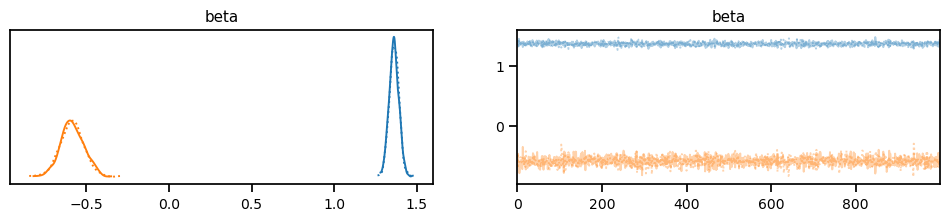

In [4]:
pm.plot_trace(trace_p, var_names=['beta']);

### Unpooled model

In [5]:
counties = radon_data.county.unique()
n_counties = counties.shape[0]
county = radon_data.county.replace(dict(zip(counties, np.arange(n_counties)))).values

with pm.Model() as unpooled_model:
    
    beta0 = pm.Normal('beta0', 0, sigma=10, shape=n_counties)
    beta1 = pm.Normal('beta1', 0, sigma=10)
    sigma = pm.HalfCauchy('sigma', 5)
    
    theta = beta0[county] + beta1*floor
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_radon)
    
    trace_u = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta1, sigma]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


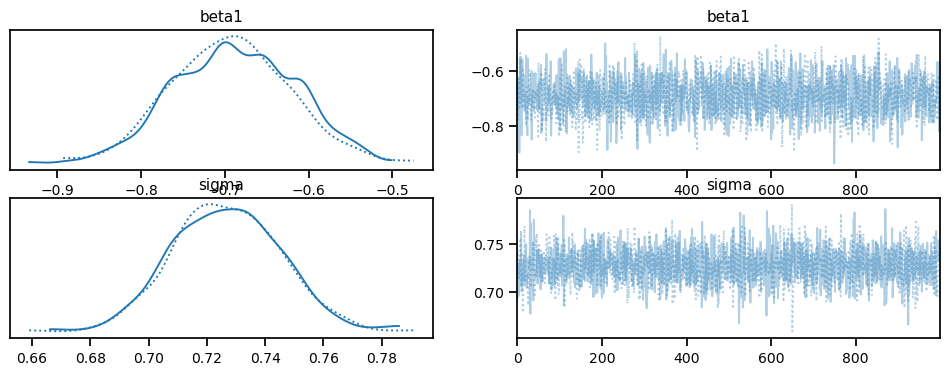

In [6]:
pm.plot_trace(trace_u, var_names=['beta1', 'sigma']);

### Hierarchical model

In [7]:
mn_counties = radon_data.county.unique()
counties = mn_counties.shape[0]
floor_measure = radon_data.floor.values
                             
with pm.Model() as hierarchical_model:
    
    # Priors
    mu_b0 = pm.Normal('mu_b0', mu=0., sigma=0.0001)
    sigma_b0 = pm.HalfCauchy('sigma_b0', 5)
    
    
    # Random intercepts
    nu = pm.Normal('nu', mu=0, sigma=1, shape=n_counties)
    beta_0 = mu_b0 + nu * sigma_b0
    # Common slope
    beta_1 = pm.Normal('beta_1', mu=0., sigma=1e5)
    
    # Model error
    sigma_y = pm.HalfCauchy('sigma_y', 5)
    
    # Expected value
    y_hat = beta_0[county] + beta_1 * floor_measure
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon)
    
    trace_h = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_b0, sigma_b0, nu, beta_1, sigma_y]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


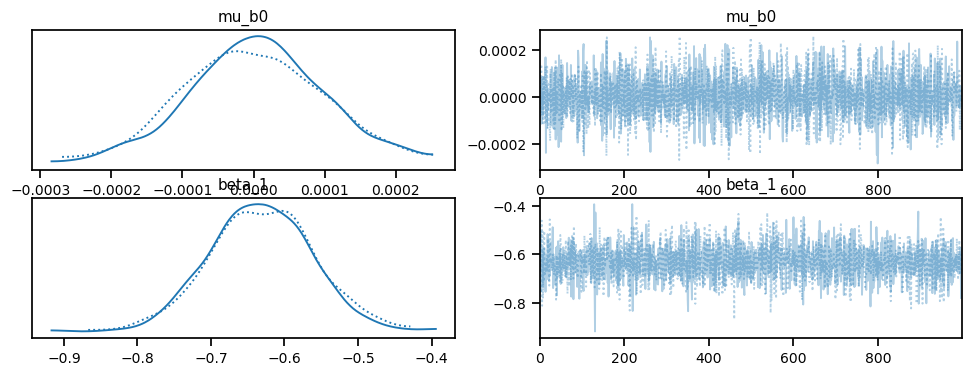

In [8]:
pm.plot_trace(trace_h, var_names=['mu_b0', 'beta_1']);

## Predictive Information Criteria

Measures of predictive accuracy are called **information criteria**, and are comprised of the log-predictive density of the data given a point estimate of the fitted model multiplied by −2 (i.e. the deviance):

$$−2 \log[p(y | \hat{\theta})]$$

As you might expect, the expected accuracy of a fitted model’s predictions of future data will generally be lower than the accuracy of the model’s predictions for observed data, even though the parameters in the model happen to be sampled from the specified prior distribution.

Why are we interested in prediction accuracy?

1. to quantify the performance of a model
2. to perform model selection 

By model selection, we may not necessarily want to choose one model over another, but we might want to put different models on the same scale. The advantage if information-theoretic measures is that candidate models do not need to be nested; even models with completely different parameterizations can be used to predict the same measurements.

Note that when candidate models have the same number of parameters, one can compare their best-fit log predictive densities directly, but when model dimensions differ, one has to make an adjustment for the tendency of a *larger model to fit data better*.

One advantage of using predictive information criteria for model comparison is that they allow us to estimate **out-of-sample predictive accuracy** using the data in our sample. All such methods are *approximations* of predictive accuracy, so they are not perfect, but they perform reasonably well.

One can naively use the log predictive density for the sample data (within-sample predictive accuracy) as an approximation of the out-of-sample predictive accuracy, but this will almost always result in an overestimate of performance.

As is popular in machine learning, **cross-validation** can be used to evaluate predictive accuracy, whereby the dataset is partitioned and each partition is allowed to be used to fit the model and evaluate the fit. However, this method is computationally expensive because it reqiures the same model to be fit to multiple subsets of the data.

We will focus here on **adjusted within-sample predictive accuracy**, using a variety of information criteria. The goal here is to get an approximately unbiased estimate of predictive accuracy which are correct in expectation.

### AIC and DIC

One approach to model selection is to use an information-theoretic criterion to identify the most appropriate model. Akaike (1973) found a formal relationship between Kullback-Leibler information (a dominant paradigm in information and coding theory) and likelihood theory. **Akaike's Information Criterion (AIC)** is an estimator of expected relative K-L information based on the maximized log-likelihood function, corrected for asymptotic bias.

$$\text{AIC} = −2 \log(L(\theta|data)) + 2K$$

AIC balances the **fit of the model** (in terms of the likelihood) with the **number of parameters** required to achieve that fit. We can easily calculate AIC from the residual sums of squares as:

$$\text{AIC} = n \log(\text{RSS}/n) + 2k$$

where $k$ is the number of parameters in the model. Notice that as the number of parameters increase, the residual sum of squares goes down, but the second term (a penalty) increases.

A limitation of AIC for Bayesian models is that it cannot be applied to hierarchical models (or any models with random effects), as counting the number of parameters in such models is problematic. A more Bayesian version of AIC is called the **deviance information criterion (DIC)**, and replaces the fixed parameter penalty with an estimate of the effective number of parameters.

$$p_{DIC} = 2\left(\log p(y | E[\theta | y]) - E_{post}[\log p(y|\theta)] \right)$$

where the second term is an average of $\theta$ over the posterior distribution:

$$\hat{p}_{DIC} = 2\left(\log p(y | E[\theta | y]) - \frac{1}{M} \sum_{j=1}^{M}\log p(y|\theta^{(j)}) \right)$$

DIC is computed as:

$$\text{DIC} = -2 \log p(y | E[\theta | y]) + 2p_{DIC}$$

Though this is an improvement over AIC, DIC is still not fully Bayesian, as it relies on a **point estimate** of the model rather than using the full posterior. As a result, it can be unstable for hierarchical models, sometimes producing estimates of effective number of parameters that is negative.

### Widely-applicable Information Criterion (WAIC)

WAIC (Watanabe 2010) is a fully Bayesian criterion for estimating out-of-sample expectation, using the **log pointwise posterior predictive density (LPPD)** and correcting for the effective number of parameters to adjust for overfitting.

The computed log pointwise predictive density is:

$$lppd_{comp} = \sum_{i=1}^N \log \left(\frac{1}{M} \sum_{j=1}^M p(y_i | \theta^{(j)}) \right)$$

The complexity adjustment here is as follows:

$$p_{WAIC} = 2\sum_{i=1}^N \left[ \log \left(\frac{1}{M} \sum_{j=1}^M p(y_i | \theta^{(j)})\right)  - \frac{1}{M} \sum_{j=1}^M \log p(y_i | \theta^{(j)})  \right]$$

so WAIC is then:

$$\text{WAIC} = -2(lppd) + 2p_{WAIC}$$

The adjustment is an approximation to the **number of unconstrained parameters** in the model (0=fully constrained, 1=no constraints). In this sense, WAIC treats the effective number of paramters as a random variable.

WAIC *averages* over the posterior distribution, and therefore is more reliable for a wider range of models.

> To run any model comparison criteria, the log-likelihood of the model must be calculated. To save on computation, it is not calculated by default in the call to `pm.sample`. To enable it during a sampling run, add the argument `idata_kwargs = {'log_likelihood': True}`; to calculate it after the fact, use `pm.compute_log_likelihood`.

In [9]:
with pooled_model:
    pm.compute_log_likelihood(trace_p)

In [10]:
from arviz import waic

pooled_waic = waic(trace_p, pooled_model)
    
pooled_waic

Computed from 2000 posterior samples and 919 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1089.85    24.97
p_waic        3.69        -

In [11]:
with unpooled_model:
    pm.compute_log_likelihood(trace_u)

In [12]:
unpooled_waic = waic(trace_u, unpooled_model)
    
unpooled_waic

Computed from 2000 posterior samples and 919 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1059.20    28.58
p_waic       83.83        -

There has been a warning during the calculation. Please check the results.

In [13]:
with hierarchical_model:
    pm.compute_log_likelihood(trace_h)

In [14]:
hierarchical_waic = waic(trace_h, hierarchical_model)
    
hierarchical_waic

Computed from 2000 posterior samples and 919 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1057.65    28.08
p_waic       80.48        -

There has been a warning during the calculation. Please check the results.

PyMC includes two convenience functions to help compare WAIC for different models. The first of this functions is `compare`, this one computes WAIC (or LOO) from a set of traces and models and returns a DataFrame.

In [15]:
df_comp_WAIC = az.compare({'hierarchical':trace_h, 'pooled':trace_p, 'unpooled':trace_u}, ic='waic', seed=RANDOM_SEED, method='BB-pseudo-BMA')
df_comp_WAIC

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
hierarchical,0,-1057.646237,80.479324,0.000000,0.707684,27.877961,0.000000,True,log
unpooled,1,-1059.203740,83.831766,1.557503,0.278044,24.867682,2.160068,True,log
pooled,2,-1089.845549,3.687890,32.199312,0.014272,28.383663,14.285266,False,log


We have many columns so let's check one by one the meaning of them:

1. The first column is the **rank order** of the models; zero is best.

2. The second column contains the **values of WAIC**. The DataFrame is always sorted from lowest to highest WAIC. The index reflects the order in which the models are passed to this function.

3. The third column is the estimated **effective number of parameters**. In general, models with more parameters will be more flexible to fit data and at the same time could also lead to overfitting. Thus we can interpret pWAIC as a penalization term, intuitively we can also interpret it as measure of how flexible each model is in fitting the data.

4. The fourth column is the **difference between the value of WAIC for the top-ranked model and the value of WAIC for each model**. For this reason we will always get a value of 0 for the first model. 

5. The fifth column contains **model weights**. Sometimes when comparing models, we do not want to select the "best" model, instead we want to perform predictions by averaging along all the models (or at least several models). Ideally we would like to perform a weighted average, giving more weight to the model that seems to explain/predict the data better. There are many approaches to perform this task, one of them is to use Akaike weights based on the values of WAIC for each model. These weights can be loosely interpreted as the probability of each model (among the compared models) given the data. One caveat of this approach is that the weights are based on point estimates of WAIC (i.e. the uncertainty is ignored).

6. The sixth column records the **standard error for the WAIC computations**. The standard error can be useful to assess the uncertainty of the WAIC estimates. Nevertheless, caution need to be taken because the estimation of the standard error assumes normality and hence could be problematic when the sample size is low.

7. dSE is the **standard error of the difference** in IC between each model and the top-ranked model. It’s always 0 for the top-ranked model. 

8. The second-last column is a flag for **warnings**. A value of `True` indicates that the computation of WAIC may not be reliable, this warning is based on an empirical determined cutoff value and need to be interpreted with caution. For more details you can read this [paper](https://arxiv.org/abs/1507.04544).

9. The last column indicates the **scale** used for the information criterion.

The second convenience function takes the output of `compare` and produces a summary plot in the style of the one used in the book [Statistical Rethinking](http://xcelab.net/rm/statistical-rethinking/) by Richard McElreath (check also [this port](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC) of the examples in the book to PyMC).

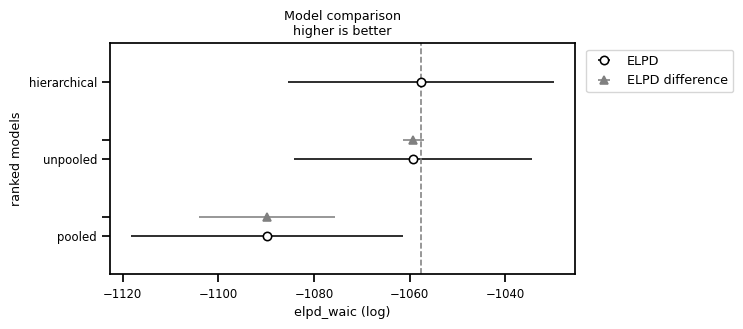

In [16]:
ax = pm.plot_compare(df_comp_WAIC);

- The empty circle represents the values of WAIC and the black error bars associated with them are the values of the standard deviation of WAIC. 
- The value of the lowest WAIC is also indicated with a vertical dashed grey line to ease comparison with other WAIC values.
- The filled black dots are the in-sample deviance of each model, which for WAIC is  2 pWAIC from the corresponding WAIC value.
- For all models except the top-ranked one we also get a triangle indicating the value of the difference of WAIC between that model and the top model and a grey errorbar indicating the standard error of the differences between the top-ranked WAIC and WAIC for each model.

### Leave-one-out Cross-validation (LOO)

LOO cross-validation is another estimate of the **out-of-sample predictive fit**. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. 

The estimate of out-of-sample predictive fit from applying LOO cross-validation to a Bayesian model is:

$$lppd_{loo} = \sum_{i=1}^N \log p_{post(-i)}(y_i) =  \sum_{i=1}^N \log \left(\frac{1}{S} \sum_{s=1}^S p(y_i| \theta^{(is)})\right)$$

so, each prediction is conditioned on $N-1$ data points, which induces an **underestimation of the predictive fit** for smaller $N$. The resulting estimate of effective samples size is:

$$p_{loo} = lppd - lppd_{loo}$$

As mentioned, using cross-validation for a Bayesian model, fitting $N$ copies of the model under different subsets of the data is computationally expensive. However, Vehtari *et al.* (2016) introduced an efficient computation of LOO from MCMC sample, which are corrected using **Pareto-smoothed importance sampling (PSIS)** to provide an estimate of point-wise out-of-sample prediction accuracy.

This involves estimating the importance sampling LOO predictive distribution

$$p(\tilde{y}_i | y_{-i}) \approx \frac{\sum_{s=1}^S w_i(\theta^{(s)}) p(\tilde{y}_i|\theta^{(s)})}{\sum_{s=1}^S w_i(\theta^{(s)})}$$

where the importance weights are:

$$w_i(\theta^{(s)}) = \frac{1}{p(y_i | \theta^{(s)})} \propto \frac{p(\theta^{(s)}|y_{-i})}{p(\theta^{(s)}|y)}$$

The predictive distribution evaluated at the held-out point is then:

$$p(y_i | y_{-i}) \approx \frac{1}{\frac{1}{S} \sum_{s=1}^S \frac{1}{p(y_i | \theta^{(s)})}}$$

However, the posterior is likely to have a *smaller variance and thinner tails* than the LOO posteriors, so this approximation induces instability due to the fact that the importance ratios can have high or infinite variance.

To deal with this instability, a generalized **Pareto distribution** fit to the upper tail of the distribution of the importance ratios can be used to construct a test for a finite importance ratio variance. If the test suggests the variance is infinite then importance sampling is halted.

LOO using Pareto-smoothed importance sampling is implemented in ArviZ in the `loo` function.

In [17]:
pooled_loo = az.loo(trace_p, pooled_model)
    
pooled_loo

Computed from 2000 posterior samples and 919 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1089.86    24.97
p_loo        3.70        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      919  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [18]:
unpooled_loo = az.loo(trace_u, unpooled_model)
    
unpooled_loo

Computed from 2000 posterior samples and 919 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1063.72    28.79
p_loo       88.34        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      878   95.5%
 (0.5, 0.7]   (ok)         32    3.5%
   (0.7, 1]   (bad)         6    0.7%
   (1, Inf)   (very bad)    3    0.3%

In [19]:
hierarchical_loo  = az.loo(trace_h, hierarchical_model)
    
hierarchical_loo

Computed from 2000 posterior samples and 919 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1061.38    28.16
p_loo       84.22        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      885   96.3%
 (0.5, 0.7]   (ok)         27    2.9%
   (0.7, 1]   (bad)         7    0.8%
   (1, Inf)   (very bad)    0    0.0%

We can also use `compare` with LOO.

In [20]:
df_comp_LOO = az.compare({'hierarchical':trace_h, 'pooled':trace_p, 'unpooled':trace_u}, ic='LOO', seed=RANDOM_SEED, method='BB-pseudo-BMA')
df_comp_LOO

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hierarchical,0,-1061.382835,84.215922,0.000000,0.769907,27.934933,0.000000,True,log
unpooled,1,-1063.715476,88.343502,2.332641,0.203922,24.868905,2.395309,True,log
pooled,2,-1089.855250,3.697591,28.472415,0.026171,28.584054,14.404506,False,log


We can also plot the results

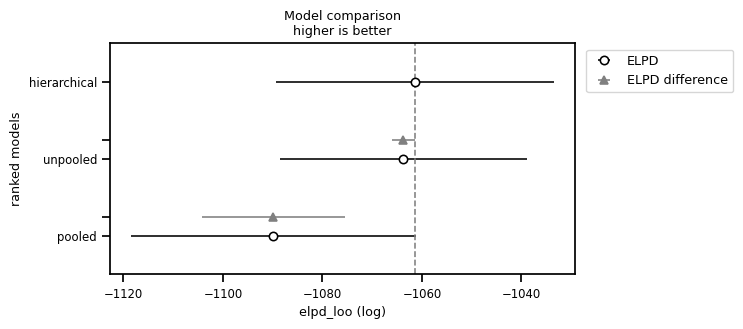

In [21]:
pm.plot_compare(df_comp_LOO);

### Interpretation

Though we might expect the hierarchical model to vastly outperform non-hierarchical models, there is little to choose between the hierarchical and unpooled models in this case, given that these two models give similar values of the information criteria. This is more clearly appreciated when we take into account the uncertainty (in terms of standard errors) of WAIC and LOO.

## Exercise: IQ Drug Model Comparison

Recall from an earlier session that we fit two models to the experimental IQ drug dataset. These models differed in that one employed a normal likelihood for the group IQ scores, while the other employed a Student-t likelihood. While the model inferences were different, it was not immediately obvious which was better. 

Run these two models again, and use `compare` to determine which is better.

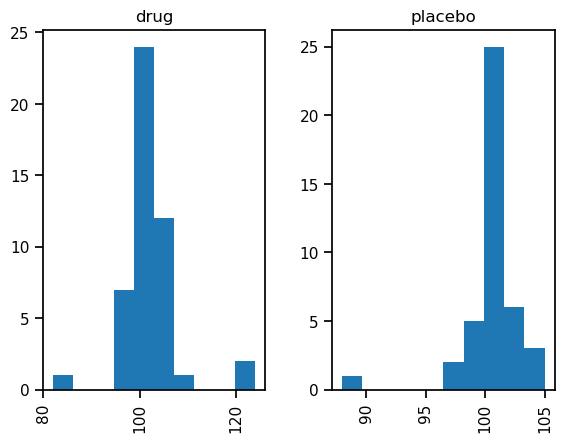

In [22]:
drug = pd.DataFrame(dict(iq=(101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101),
                         group='drug'))
placebo = pd.DataFrame(dict(iq=(99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99),
                            group='placebo'))

trial_data = pd.concat([drug, placebo], ignore_index=True)
trial_data.hist('iq', by='group');

In [29]:
with pm.Model() as drug_model:
    
    mu_0 = pm.Normal('mu_0', 100, sigma=10)
    mu_1 = pm.Normal('mu_1', 100, sigma=10)

    sigma_0 = pm.Uniform('sigma_0', lower=0, upper=20)
    sigma_1 = pm.Uniform('sigma_1', lower=0, upper=20)

    nu = pm.Exponential('nu_minus_one', 1/30) 

    placebo_like = pm.StudentT('placebo_like', nu=nu, mu=mu_0, sigma=sigma_0, observed=placebo.iq)
    drug_like = pm.StudentT('drug_like', nu=nu, mu=mu_1, sigma=sigma_1, observed=drug.iq)

    trace_t = pm.sample()

    pm.compute_log_likelihood(trace_t)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, mu_1, sigma_0, sigma_1, nu_minus_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [37]:
trace_t.log_likelihood["total_like"] = trace_t.log_likelihood.placebo_like + trace_t.log_likelihood.drug_like

In [30]:
with pm.Model() as drug_model_norm:
    
    mu_0 = pm.Normal('mu_0', 100, sigma=10)
    mu_1 = pm.Normal('mu_1', 100, sigma=10)

    sigma_0 = pm.Uniform('sigma_0', lower=0, upper=20)
    sigma_1 = pm.Uniform('sigma_1', lower=0, upper=20)

    placebo_like = pm.Normal('placebo_like', mu=mu_0, sigma=sigma_0, observed=placebo.iq)
    drug_like = pm.Normal('drug_like', mu=mu_1, sigma=sigma_1, observed=drug.iq)

    trace_n = pm.sample()

    pm.compute_log_likelihood(trace_n)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_0, mu_1, sigma_0, sigma_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [38]:
trace_n.log_likelihood["total_like"] = trace_n.log_likelihood.placebo_like + trace_n.log_likelihood.drug_like

In [39]:
az.compare({'Student T': trace_t, "Normal": trace_n}, ic='LOO', seed=RANDOM_SEED, method='BB-pseudo-BMA', var_name='total_like')

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Student T,0,-9618.754039,223.908492,0.000000,1.0,84.478212,0.000000,False,log
Normal,1,-11363.989292,574.043563,1745.235253,0.0,134.045399,82.016785,True,log



---

## Reference

[Burnham, K. and Anderson, K. (2013). Model Selection and Multimodel Inference: A Practical Information-Theoretic Approach](https://www.amazon.co.uk/Model-Selection-Multimodel-Inference-Information-Theoretic/dp/1441929738)

[Gelman, A., Hwang, J., & Vehtari, A. (2014). Understanding predictive information criteria for Bayesian models. Statistics and Computing, 24(6), 997–1016.](http://doi.org/10.1007/s11222-013-9416-2)

[Vehtari, A, Gelman, A, Gabry, J. (2016). Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC. Statistics and Computing](http://link.springer.com/article/10.1007/s11222-016-9696-4)